<a href="https://colab.research.google.com/github/mickwelli/DEAfr-RSITS/blob/master/Use_cases/NorthernRangelandsTrust/NorthernRangelandsTrust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Northern Rangelands Trust Community Conservancy Vegetation Index Analysis

This notebook prepares and analysis vegetation index data for community conservancies in northern Kenya.

The aim of this notebook is to aggregate vegetation index data from satellites, in the form of the Normalised Difference Vegetation Index (NDVI) and the Enhanced Vegetation Index (EVI), for each of the conservancies.

The timeseries of vegetation indices can be used to analyse and identify trends in vegetation presence and health. They can also be used to quantify and understand phenological patterns.

## Install and import packages

In [36]:
pip install odc-stac deafrica-tools pystac_client session-info matplotlib jupyter_dash rioxarray datacube xagg ruptures odc.algo dash dash-core-components dash-html-components plotly --quiet

In [37]:
import matplotlib.pyplot as plt
import session_info
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import odc.algo
import xagg as xa
import xarray as xr
import datacube
import os

from datacube.utils import masking
from pystac_client import Client
from odc.stac import configure_rio, stac_load
from plotly.subplots import make_subplots
from IPython.display import Image
from deafrica_tools.get_config import get_product_config
from deafrica_tools.plotting import rgb
from deafrica_tools.plotting import xr_animation

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.express as px
import plotly.io as pio

from jupyter_dash import JupyterDash
from dash import html

In [38]:
session_info.show()

## Load Community Conservancy Polygons

We load community conservancy polygons from the Northern Rangelands Trust, within which we will be conducting the analyses and data preparation.

Ensure that the shapefile and associated files are stored in a local directory called 'data'.

<Axes: >

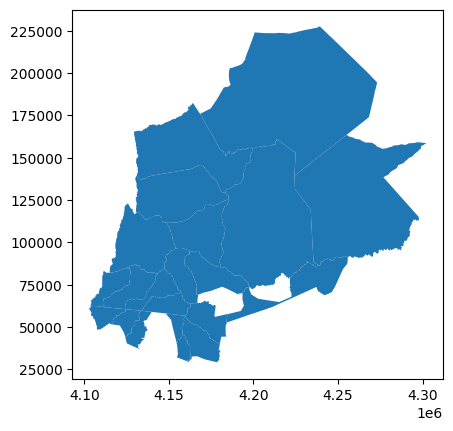

In [39]:
nrt_cc = gpd.read_file('data/NRT_Carbon.shp')

nrt_cc.plot()

We can inspect the information contained in the Geopandas object. It contains the name of the conservancy, its area, population (male and female), and number of households.

In [40]:
nrt_cc

,NAME,Area_Acres,County,YearEstabl,TotalPopul,Male,Female,Households,Area_Ha,geometry
0,Naapu,69842.1452998588,Isiolo,None,3378,1621,1757,709,28264.1134260928,"POLYGON ((4147319.534 84274.138, 4147326.852 8..."
1,Nanapa,62920.2010639737,Isiolo,None,6907,3276,3631,1534,25462.9019774441,"POLYGON ((4111441.019 66487.18, 4111426.862 66..."
2,Narupa,91487.3363723155,Isiolo,None,5206,2468,2738,1097,37023.6114766574,"POLYGON ((4128259.354 66582.55, 4128258.296 66..."
3,Nanapisho,61158.3230186806,Isiolo,None,4646,2219,2427,976,24749.8952291361,"POLYGON ((4157461.157 70132.6, 4157461.158 701..."
4,Kalepo,449241.793521901,Samburu,None,7585,3738,3847,1791,181801.70373246,"POLYGON ((4183623.317 129002.216, 4183510.831 ..."
5,Biliqo Bulesa,931695.603768225,Isiolo,None,7665,4083,3582,1686,377043.833783129,"POLYGON ((4292477.273 104773.577, 4292455.696 ..."
6,Sera,839594.957384699,Samburu,None,5356,2710,2646,1577,339772.024550693,"MULTIPOLYGON (((4186479.852 82513.585, 4186479..."
7,Meibae,250524.462625422,Samburu,None,12497,5784,6713,2884,101383.6530544,"POLYGON ((4125795.552 122820.163, 4126187.816 ..."
8,WestGate,89696.1211287514,Samburu,None,7183,3413,3769,1607,36298.7323854256,"POLYGON ((4156100.164 96608.558, 4156880.18 96..."
9,Kalama,122569.294760753,Samburu,None,9014,4441,4573,2263,49602.0337691594,"MULTIPOLYGON (((4183617.78 84938.419, 4183619...."


### Select conservancy for analysis

Due to data volumes, this notebook deals with one selected conservancy only, which can be alternated. The cell below selects the conservancy we'll be dealing with and prints its name.

In [234]:
selected_cc_ix = 4 # select the conservancy by changing this index number

nrt_cc.iloc[selected_cc_ix].NAME

'Kalepo'

### Set resolution

Use the area attribute to set optimal resolution for approx 100 x 100 pixels

In [235]:
# A factor of 0.7 assumes the polygon fills about 70% of the image rectangle
resolution_m = np.sqrt(float(nrt_cc.iloc[selected_cc_ix].Area_Ha) / 0.7)

resolution_m

np.float64(509.6240963865426)

## Access Digital Earth Africa Monthly NDVI

Next, we set the configuration for the [Digital Earth Africa mean NDVI and anomaly product](https://www.digitalearthafrica.org/platform-resources/services/mean-ndvi-and-anomalies). This product provides us with an 'off-the-shelf' NDVI mean and anomaly value for every month from January 2017 to present.  

In [236]:
config = {
    "ndvi_anomaly": {
        "assets": {
            "*": {
                "data_type": "float32",
                "nodata": 'nan',
                "unit": "1",
            },
        },
    }
}

To access Digital Earth Africa data, we set the AWS endpoint and STAC catalog.

In [237]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

### Loading parameters

Next, we define the parameters for loading the NDVI data. We use the selected conservancy boundary. The start date is set as the beginning of 2013, although the product is only available from 2017.

In [238]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = nrt_cc.to_crs('EPSG:4326').iloc[selected_cc_ix].geometry.bounds

# Set a start and end date
start_date = "2017-01-01"
end_date = "2024-12-31"

# Set the STAC collections
collections = ["ndvi_anomaly"]

Now that the configuration is set, we can query the database and print the number of STAC items returned.

In [241]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 190 datasets


### Load NDVI data

NDVI data is loaded below with reference to the STAC items. We set the resolution as 30m, the native resolution of the NDVI mean and anomaly data.

This returns an xarray object which we can see contains space and time dimensions and `ndvi_mean` as a measurement or variable.

In [242]:
crs = "EPSG:6933"
resolution = resolution_m

ds = stac_load(
    items,
    bands=("ndvi_mean"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 6MB
Dimensions:      (y: 121, x: 121, time: 95)
Coordinates:
  * y            (y) float64 968B 2.102e+05 2.097e+05 ... 1.496e+05 1.491e+05
  * x            (x) float64 968B 3.579e+06 3.579e+06 ... 3.639e+06 3.64e+06
  * time         (time) datetime64[ns] 760B 2017-01-01 2017-02-01 ... 2024-11-01
    spatial_ref  int32 4B 6933
Data variables:
    ndvi_mean    (time, y, x) float32 6MB dask.array<chunksize=(1, 121, 121), meta=np.ndarray>

## NDVI Timeseries

### Clip NDVI to conservancy

We use the `rioxarray` package to clip the NDVI data to the bounds of the conservancy of interest.

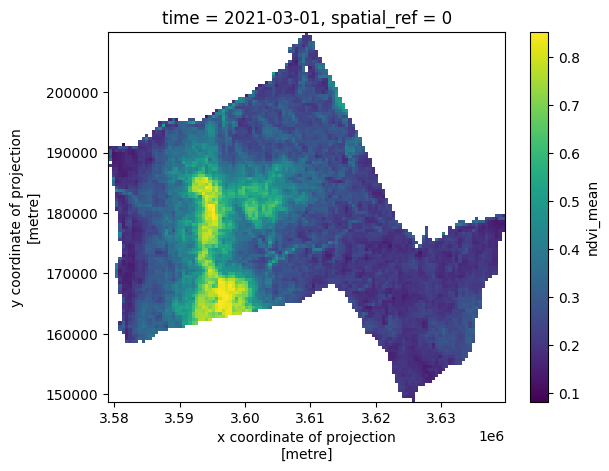

In [243]:
ds_clip = ds.rio.clip(gpd.GeoDataFrame(nrt_cc.iloc[selected_cc_ix]).transpose().set_geometry('geometry').geometry.values, nrt_cc.crs)

ds_clip.ndvi_mean.isel(time=50).plot()

## Create spatial animation

### Plot time series

Next, we can plot the timeseries of NDVI values (spatial mean) from 2017 to 2024. We first creat a timeseries object, `ts`, then omit any 0 values, which reflect empty dates.

In [244]:
time = pd.to_datetime(ds_clip.coords["time"].values)
time_labels = [t.strftime("%Y-%m") for t in time] # e.g., ['2020-01', '2020-02', ...]

# Get the series for the line plot
ts = ds_clip.mean(["y", "x"]).ndvi_mean.to_series()
df_ts = ts.reset_index(name='ndvi_mean') # DataFrame with 'time' column for easy slicing


# Get the full X-axis range for the line plot
time_min = df_ts['time'].min()
time_max = df_ts['time'].max()

In [245]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("NDVI Time Series", "NDVI Heatmap Animation")
)

# --- Initial line plot ---
initial_line_y = np.full(len(df_ts), np.nan)
initial_line_y[0] = df_ts['ndvi_mean'][0]

fig.add_trace(
    go.Scatter(
        x=df_ts['time'],
        y=initial_line_y,
        mode='lines',
        name='NDVI Mean',
        line=dict(color='blue', width=3)
    ),
    row=1, col=1
)

# --- Initial heatmap ---
initial_heatmap_z = ds_clip.isel(time=0).ndvi_mean.values
lon = ds_clip.isel(time=0).x.values
lat = ds_clip.isel(time=0).y.values
fig.add_trace(
    go.Heatmap(
        z=initial_heatmap_z,
        x=lon,
        y=lat,
        colorscale="YlGn",
        zmin=0, zmax=1,
        #name="NDVI Map"
    ),
    row=1, col=2
)

# --- Frames ---
frames = []
for i, t in enumerate(time_labels):
    new_line_y = np.full(len(df_ts), np.nan)
    new_line_y[:i+1] = df_ts['ndvi_mean'].head(i + 1).values
    heatmap_z = ds_clip.isel(time=i).ndvi_mean.values

    frames.append(
        go.Frame(
            data=[
                go.Scatter(y=new_line_y),
                go.Heatmap(z=heatmap_z)
            ],
            traces=[0, 1],
            name=str(i),
            #layout=go.Layout(title_text=f"NDVI Animation: {t}")
        )
    )

# --- Layout ---
fig.update_layout(
    height=500,
    xaxis=dict(range=[time_min, time_max]),
    yaxis=dict(range=[df_ts['ndvi_mean'].min(), df_ts['ndvi_mean'].max()]),
    xaxis2=dict(title="Longitude", scaleanchor="y2", scaleratio=1),
    yaxis2=dict(title="Latitude"),

    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 200, "redraw": True},
                        "transition": {"duration": 0, "easing": "linear"},
                        "fromcurrent": True,
                        "mode": "immediate"
                    }
                ]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [
                    [None],
                    {"frame": {"duration": 0}, "mode": "immediate"}
                ]
            }
        ]
    }],

    sliders=[{
        "active": 0,
        "steps": [
            {"label": t, "method": "animate", "args": [[str(i)], {"mode": "immediate", "frame": {"redraw": True}}]}
            for i, t in enumerate(time_labels)
        ]
    }]
)

# --- Final Figure ---
final_fig = go.Figure(data=fig.data, layout=fig.layout, frames=frames)
#final_fig.show()

In [246]:
pio.write_json(final_fig, f"{nrt_cc.iloc[selected_cc_ix].NAME}_NDVI.json")

## Load fractional cover

In [247]:
config = get_product_config("fc_ls_summary_annual", profile="deafrica")

In [248]:
# Set a start and end date
start_date = "2000-01-01"
end_date = "2024-12-31"

# Set the STAC collections
collections = ["fc_ls_summary_annual"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 50 datasets


In [249]:
crs = "EPSG:6933"
resolution = resolution_m

ds = stac_load(
    items,
    bands=("pv_pc_50", "npv_pc_50"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)


ds = ds.rio.clip(gpd.GeoDataFrame(nrt_cc.iloc[selected_cc_ix]).transpose().set_geometry('geometry').geometry.values, nrt_cc.crs)

ds = ds.where(ds!=255)

In [250]:
ds['gc'] = ds.pv_pc_50 + ds.npv_pc_50

ds

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 25, y: 120, x: 119)
Coordinates:
  * time         (time) datetime64[ns] 200B 2000-01-01 2001-01-01 ... 2024-01-01
  * y            (y) float64 960B 2.097e+05 2.092e+05 ... 1.496e+05 1.491e+05
  * x            (x) float64 952B 3.579e+06 3.58e+06 ... 3.639e+06 3.639e+06
    spatial_ref  int64 8B 0
Data variables:
    pv_pc_50     (time, y, x) float32 1MB dask.array<chunksize=(1, 120, 119), meta=np.ndarray>
    npv_pc_50    (time, y, x) float32 1MB dask.array<chunksize=(1, 120, 119), meta=np.ndarray>
    gc           (time, y, x) float32 1MB dask.array<chunksize=(1, 120, 119), meta=np.ndarray>

In [251]:
time = pd.to_datetime(ds.coords["time"].values)
time_labels = [t.strftime("%Y-%m") for t in time] # e.g., ['2020-01', '2020-02', ...]

# Get the series for the line plot
ts_pv = ds.mean(["y", "x"]).pv_pc_50.to_series()
df_pv_ts = ts_pv.reset_index(name='Green Veg') # DataFrame with 'time' column for easy slicing

ts_npv = ds.mean(["y", "x"]).npv_pc_50.to_series()
df_npv_ts = ts_npv.reset_index(name='Non-green Veg') # DataFrame with 'time' column for easy slicing


# Get the full X-axis range for the line plot
time_min = df_ts['time'].min()
time_max = df_ts['time'].max()

In [252]:
ts_gc = pd.merge(df_pv_ts, df_npv_ts)

ts_gc = pd.melt(ts_gc, id_vars=['time'], value_vars=['Green Veg', 'Non-green Veg'], value_name="Percent Cover", var_name="Cover Type")

ts_gc

,time,Cover Type,Percent Cover
0,2000-01-01,Green Veg,15.595912
1,2001-01-01,Green Veg,19.872019
2,2002-01-01,Green Veg,37.045883
3,2003-01-01,Green Veg,44.438175
4,2004-01-01,Green Veg,25.935228
5,2005-01-01,Green Veg,21.179102
6,2006-01-01,Green Veg,15.006019
7,2007-01-01,Green Veg,38.276524
8,2008-01-01,Green Veg,22.903803
9,2009-01-01,Green Veg,15.812893


In [253]:
fig = px.area(ts_gc, x="time", y="Percent Cover", line_group="Cover Type", color ="Cover Type")
fig.show()

In [254]:
df_pivot = ts_gc.pivot(index='time', columns='Cover Type', values='Percent Cover').reset_index()
cover_types = [c for c in df_pivot.columns if c != 'time']

# Optional: Define specific colors for your cover types
color_map = {
    'Green Veg': 'green',   # Photosynthetic Vegetation
    'Non-green Veg': 'Brown'   # Non-Photosynthetic Vegetation
}
# Fallback if cover types don't match keys above
def get_color(ctype):
    return color_map.get(ctype, None)

# --- 2. Initialize Figure ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Ground Cover Area", "Ground Cover Heatmap"),
    horizontal_spacing=0.15
)

# --- 3. Add Initial Area Plot Traces (Row 1, Col 1) ---
# We add one trace per cover type.
# For the initial state (frame 0), we only show the first data point.
for c in cover_types:
    fig.add_trace(
        go.Scatter(
            x=df_pivot['time'].iloc[:1],   # Start with just the first time step
            y=df_pivot[c].iloc[:1],
            name=c,
            mode='none',                   # 'none' removes the top line, 'lines' keeps it
            stackgroup='one',              # <--- This enables the stacking magic
            fillcolor=get_color(c),
            line=dict(color=get_color(c))  # Border color (if mode includes lines)
        ),
        row=1, col=1
    )

# --- 4. Add Initial Heatmap Trace (Row 1, Col 2) ---
initial_heatmap_z = ds.isel(time=0).gc.values
custom_earth_scale = [
    [0.0, "rgb(210, 180, 140)"], # Tan/Brown (Bare Soil)
    [0.2, "rgb(225, 225, 150)"], # Light Yellowish (Sparse)
    [0.5, "rgb(173, 255, 47)"],  # Yellow-Green (Grass)
    [1.0, "rgb(0, 100, 0)"]      # Dark Green (Dense)
]
fig.add_trace(
    go.Heatmap(
        z=initial_heatmap_z,
        x=lon,
        y=lat,
        colorscale=custom_earth_scale,
        zmin=0, zmax=100,
        colorbar=dict(x=1.02) # Move colorbar slightly right
    ),
    row=1, col=2
)

legend_settings = dict(
    x=0.425,          # Top-right of the left panel (0.85 width / 2)
    y=1,
    xanchor="right",
    yanchor="top",
    xref="paper",     # Crucial for stable positioning
    yref="paper",
    bgcolor="rgba(255,255,255,0.6)",
    bordercolor="Black",
    borderwidth=1
)

# --- 5. Build Frames ---
frames = []
num_cover_traces = len(cover_types)

for i, t in enumerate(time_labels):
    frame_data = []

    # A. Update every Cover Type trace (Growing effect)
    # We slice the data from start (0) to current index (i+1)
    for c in cover_types:
        frame_data.append(
            go.Scatter(
                x=df_pivot['time'].iloc[:i+1],
                y=df_pivot[c].iloc[:i+1]
            )
        )

    # B. Update Heatmap trace (Changing slice)
    heatmap_z = ds.isel(time=i).gc.values
    frame_data.append(
        go.Heatmap(z=heatmap_z)
    )

    # C. Create the Frame
    # We must explicitly list indices for ALL traces we are updating.
    # Indices: 0 to N-1 are cover types, Index N is the heatmap.
    trace_indices = list(range(num_cover_traces + 1))

    frames.append(
        go.Frame(
            data=frame_data,
            traces=trace_indices,
            name=str(i),
            layout={"legend": legend_settings}
        )
    )
frame_names = [str(k) for k in range(len(time_labels))]
# --- 6. Update Layout ---
fig.update_layout(
    width=1000,
    height=500,
    margin=dict(t=80, l=50, r=50, b=50),
    # Fix Y-axis for Area Plot (Percent is usually 0-100)
    yaxis=dict(range=[0, 100], title="Percent Cover (%)"),
    xaxis=dict(range=[df_pivot['time'].min(), df_pivot['time'].max()]),

    # Geospatial axis settings
    xaxis2=dict(title="Longitude", scaleanchor="y2", scaleratio=1),
    yaxis2=dict(title="Latitude"),

    legend=dict(
        x=0.425,          # Top-right of left panel
        y=1.0,            # Top aligned
        xanchor="right",
        yanchor="top",
        xref="paper",
        yref="paper",
        bgcolor="rgba(255,255,255,0.6)",
        bordercolor="Black",
        borderwidth=1
    ),
    uirevision='constant',

    # Animation Controls (Same as your original)
    updatemenus=[{
        "type": "buttons",
        "showactive": False,
        "y": 1.15,
        "x": -0.1,
        "xanchor": "left",
        "yanchor": "top",
        "pad": {"t": 0, "r": 10},
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [
                    frame_names,
                    {
                        "frame": {"duration": 500, "redraw": True}, # <--- FIX 2: Slower duration (500ms)
                        "transition": {"duration": 0},              # <--- FIX 3: No transition (Heatmaps can't transition)
                        "fromcurrent": True,
                        "mode": "immediate"
                    }
                ]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [
                    [None],
                    {
                        "frame": {"duration": 0, "redraw": False},
                        "mode": "immediate",
                        "transition": {"duration": 0}
                    }
                ]
            }
        ]
    }],
    sliders=[{
        "active": 0,
        "steps": [
            {"label": str(t), "method": "animate", "args": [[str(i)], {"mode": "immediate", "frame": {"redraw": True}}]}
            for i, t in enumerate(time_labels)
        ]
    }]
)

# --- 7. Final Figure Assembly ---
final_fig = go.Figure(data=fig.data, layout=fig.layout, frames=frames)

final_fig.layout.legend = go.layout.Legend(
    x=0.425,          # Top-right of left panel
    y=0.9,            # Top aligned
    xanchor="right",
    yanchor="top",
    xref="paper",
    yref="paper",
    bgcolor="rgba(255,255,255,0.6)",
    bordercolor="Black",
    borderwidth=1
)

# Explicitly overwrite margins to ensure header space
final_fig.layout.margin = go.layout.Margin(t=80, l=50, r=50, b=50)

# Lock the UI state so it doesn't reset on interaction
final_fig.layout.uirevision = 'constant'
pio.write_json(final_fig, f"{nrt_cc.iloc[selected_cc_ix].NAME}_GroundCover.json")
#final_fig.show()

# Load Landsat Geomedian

Long term annual geomedian for visualisation with rainfall.

In [255]:
config_ls8_9 = get_product_config("gm_ls8_ls9_annual", profile="deafrica")

config_ls8 = get_product_config("gm_ls8_annual", profile="deafrica")

config_ls5_7 = get_product_config("gm_ls5_ls7_annual", profile="deafrica")

In [256]:
# Set a start and end date
start_date = "2000-01-01"
end_date = "2024-12-31"

# Set the STAC collections
collections = ["gm_ls8_ls9_annual"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

ds_89 = stac_load(items,
             bands=['red', 'green', 'blue'],
             crs=crs,
             resolution = resolution_m,
             groupby="solar_day",
             stac_cfg=config_ls8_9,
             bbox=bbox
             )

Found: 8 datasets


In [257]:
# Set the STAC collections
collections = ["gm_ls5_ls7_annual"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

ds_57 = stac_load(items,
             bands=['red', 'green', 'blue'],
             crs=crs,
             resolution = resolution_m,
             groupby="solar_day",
             stac_cfg=config_ls5_7,
             bbox=bbox
             )

Found: 26 datasets


In [258]:
# Set the STAC collections
collections = ["gm_ls8_annual"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

ds_8 = stac_load(items,
             bands=['red', 'green', 'blue'],
             crs=crs,
             resolution = resolution_m,
             groupby="solar_day",
             stac_cfg=config_ls8,
             bbox=bbox
             )

Found: 16 datasets


In [259]:
ds = xr.concat([ds_57, ds_8, ds_89], dim='time')

ds

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 25, y: 121, x: 121)
Coordinates:
  * time         (time) datetime64[ns] 200B 2000-01-01 2001-01-01 ... 2024-01-01
  * y            (y) float64 968B 2.102e+05 2.097e+05 ... 1.496e+05 1.491e+05
  * x            (x) float64 968B 3.579e+06 3.579e+06 ... 3.639e+06 3.64e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (time, y, x) uint16 732kB 1841 1766 1533 ... 1719 1615 1482
    green        (time, y, x) uint16 732kB 1275 1252 1149 ... 1229 1192 1061
    blue         (time, y, x) uint16 732kB 840 839 810 802 ... 703 754 727 641

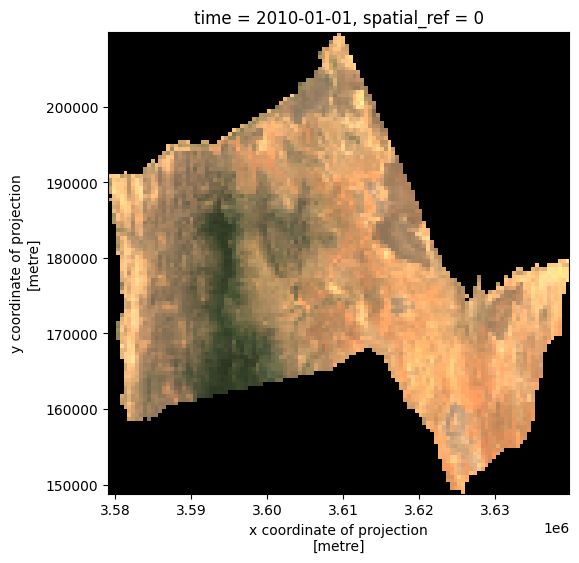

In [260]:
ds = ds.rio.clip(gpd.GeoDataFrame(nrt_cc.iloc[selected_cc_ix]).transpose().set_geometry('geometry').geometry.values, nrt_cc.crs)

rgb(ds.isel(time=10))

### Load Rainfall Monthly

CHIRPS monthly rainfall

In [261]:
config = get_product_config("rainfall_chirps_monthly", profile="deafrica")

# Set the STAC collections
collections = ["rainfall_chirps_monthly"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

ds_rf_year = stac_load(items,
             crs=crs,
             resolution = 5000,
             groupby="solar_day",
             stac_cfg=config,
             bbox=bbox
             ).resample(time='1YE').sum()

Found: 296 datasets


In [262]:
# mean across years
rf_mean = ds_rf_year.mean('time')

#calculate annual std dev
rf_std = ds_rf_year.std('time')

## Calculate std anomalies

In [263]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_rf_year,
    rf_mean,
    rf_std,
    output_dtypes=[rf_mean.rainfall.dtype],
    dask="allowed"
).compute().mean(['y', 'x']).to_dataframe().drop(
    ['spatial_ref'], axis=1).fillna(0)

In [264]:
ds_rf_year_1D = ds_rf_year.mean(['y', 'x']).to_dataframe().drop(
    ['spatial_ref'], axis=1).fillna(0)

## Rainfall animation

In [266]:
bands = ['red', 'green', 'blue']
times = ds_rf_year_1D.index
time_strings = times.strftime("%Y")
num_years = len(time_strings)

def get_rgb_image(dataset, time_idx, normalization_val):
    # Select time slice
    # Transpose to (Height, Width, Bands) which Plotly expects
    # Assuming bands order in dataset is Red, Green, Blue

    # Extract raw values
    rgb_data = dataset[bands].isel(time=time_idx).to_array().transpose('y', 'x', 'variable').values

    # Clip and Normalize using the logic from your matplotlib code
    rgb_data = np.clip(rgb_data, 0, 3000)

    # Avoid division by zero
    if normalization_val == 0: normalization_val = 1

    rgb_normalized = (rgb_data / normalization_val) * 255

    # Convert to unsigned 8-bit integer (standard for images)
    return rgb_normalized.astype(np.uint8)

# Calculate the fixed normalization value based on time=0 (as in your code)
# "np.max(ds[bands].isel(time=0)...)"
initial_slice = ds[bands].isel(time=0).to_array().values
norm_max = np.max(np.clip(initial_slice, 0, 3000))

# --- 2. Setup Layout (Left Panel Spans 2 Rows) ---
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4], # Give map more width
    # This spec allows the subplot in (1,1) to span 2 rows
    specs=[
        [{"rowspan": 2}, {}],
        [None,           {}]
    ],
    subplot_titles=("Satellite Imagery", "Annual Rainfall", "Rainfall Anomaly"),
    horizontal_spacing=0.1,
    vertical_spacing=0.15
)

# Time labels for iteration
times = ds_rf_year_1D.index
time_strings = times.strftime("%Y")

# --- 3. Add Initial Traces (Time 0) ---

# A. Satellite Image (Row 1, Col 1, Spanning 2 rows)
initial_img = get_rgb_image(ds, 0, norm_max)
fig.add_trace(
    go.Image(z=initial_img, name="Satellite"),
    row=1, col=1
)

# B. Annual Rainfall (Row 1, Col 2)
fig.add_trace(
    go.Bar(
        x=time_strings[:1],
        y=ds_rf_year_1D.rainfall.iloc[:1],
        marker_color='blue',
        name="Rainfall",
        showlegend=False
    ),
    row=1, col=2
)

# C. Rainfall Anomaly (Row 2, Col 2)
# Determine color for first point
first_val = stand_anomalies.rainfall.iloc[0]
first_color = 'green' if first_val > 0 else 'brown'

fig.add_trace(
    go.Bar(
        x=time_strings[:1],
        y=stand_anomalies.rainfall.iloc[:1],
        marker_color=[first_color],
        name="Anomaly",
        showlegend=False
    ),
    row=2, col=2
)

# --- 4. Build Animation Frames ---
frames = []

for i in range(len(times)):
    # 1. Image Data
    img_z = get_rgb_image(ds, i, norm_max)

    # 2. Rainfall Data (Grow the bar chart)
    rain_x = time_strings[:i+1]
    rain_y = ds_rf_year_1D.rainfall.iloc[:i+1]

    # 3. Anomaly Data (Grow + Color Logic)
    anom_x = time_strings[:i+1]
    anom_y = stand_anomalies.rainfall.iloc[:i+1]
    # Replicate your map logic: (stand_anomalies.rainfall > 0).map({True: 'g', False: 'brown'})
    anom_colors = ['green' if v > 0 else 'brown' for v in anom_y]

    frames.append(
        go.Frame(
            data=[
                go.Image(z=img_z),          # Update Trace 0 (Image)
                go.Bar(x=rain_x, y=rain_y), # Update Trace 1 (Rainfall)
                go.Bar(x=anom_x, y=anom_y, marker_color=anom_colors) # Update Trace 2 (Anomaly)
            ],
            traces=[0, 1, 2], # Explicitly tell Plotly to update these 3 traces
            name=str(i)
        )
    )

frame_names = [str(k) for k in range(len(times))]

# --- 5. Update Layout (Styling & Controls) ---
fig.update_layout(
    height=600,
    width=1000, # Explicit width helps JSON stability
    margin=dict(t=80, l=50, r=50, b=50),

    xaxis2=dict(
        #title="Year",
        # We set the range from -0.5 (before the first bar)
        # to len - 0.5 (after the last bar).
        range=[-0.5, num_years - 0.5],
        showticklabels = False
    ),

    xaxis3=dict(
        #title="Year",
        range=[-0.5, num_years - 0.5]
    ),


    # Rainfall Axis
    yaxis2=dict(
        range=[0, ds_rf_year_1D.rainfall.max() + 100],
        title="Rainfall (mm)"
    ),

    # Anomaly Axis
    yaxis3=dict(
        range=[-4, 4],
        title="Std Dev"
    ),

    # Play/Pause Controls
    updatemenus=[{
        "type": "buttons",
        "showactive": False,
        "y": 1.1, "x": -0.05,
        "xanchor": "left", "yanchor": "top",
        "pad": {"t": 0, "r": 10},
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 500, "redraw": True},
                        "transition": {"duration": 0, "easing": "linear"}, # <--- CRITICAL FIX
                        "fromcurrent": True,
                        "mode": "immediate"}]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                        "mode": "immediate",
                        "transition": {"duration": 0}}]
            }
        ]
    }],
    sliders=[{
        "active": 0,
        "steps": [
            {
                "label": str(t),
                "method": "animate",
                "args": [[str(i)], {"mode": "immediate", "frame": {"redraw": True}}]
            }
            for i, t in enumerate(time_strings)
        ]
    }]
)

# Add the horizontal line at 0 for the Anomaly plot (Row 2, Col 2)
fig.add_shape(
    type="line", line=dict(dash="dash", color="black"),
    x0=ds_rf_year_1D.index.min(), x1=ds_rf_year_1D.index.max(), y0=0, y1=0,
    row=2, col=2
)

# --- 6. Final Object & JSON Export ---
final_fig = go.Figure(data=fig.data, layout=fig.layout, frames=frames)

# Ensure the title and layout are locked in
#final_fig.update_layout(title_text="Annual Rainfall & Anomalies")
pio.write_json(final_fig, f"{nrt_cc.iloc[selected_cc_ix].NAME}_Rainfall.json")
#final_fig.show()

## Load Landsat data

The NDVI mean and anomaly product begins in 2017 because this was when the Sentinel-2 satellite was launched, and the product combines data from Landsat and Sentinel-2.

In this instance, we are interested in a period from 2013, so we must use Landsat. We set the configuration and search the STAC catalog in a similar manner to the NDVI product.

In [ ]:
config = {
    "ls8_sr": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "QA_PIXEL": {
                "data_type": "uint16",
                "nodata": 1,
                "unit": "bit_index",
            },
        },
    }
}

Next, we search the STAC catalog for datasets that match our query. Given the time period we set from 2017 to  2024, we can use Landsat-8 and Landsat-9.

In [ ]:
# Set the STAC collections
collections = ["ls8_sr", "ls9_sr"]

# Set a start and end date
start_date = "2013-01-01"
end_date = "2024-12-31"

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

The cell below loads data from the STAC items returned. We load the bands we need to calculate the Enhanced Vegetation Index (EVI) and the quality pixel band to conduct cloud masking.

In [ ]:
crs = "EPSG:6933"
resolution = 100

ds = stac_load(
    items,
    bands=("SR_B2", "SR_B4", "SR_B5", "QA_PIXEL"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

### Cloud masking

We have to define the cloud mask band attributes to conduct cloud masking. These can be found in the [definition documentation](https://explorer.digitalearth.africa/products/ls9_sr#definition-doc) on Digital Earth Africa Explorer.

In [ ]:
ds.QA_PIXEL.attrs = {'units': 'bit_index',
                    'nodata': 1,
                    'flags_definition': {'snow': {'bits': 5,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'clear': {'bits': 6, 'values': {'0': False, '1': True}},
                      'cloud': {'bits': 3,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'water': {'bits': 7, 'values': {'0': 'land_or_cloud', '1': 'water'}},
                      'cirrus': {'bits': 2,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'nodata': {'bits': 0, 'values': {'0': False, '1': True}},
                      'cloud_shadow': {'bits': 4,
                      'values': {'0': 'not_high_confidence', '1': 'high_confidence'}},
                      'dilated_cloud': {'bits': 1, 'values': {'0': 'not_dilated', '1': 'dilated'}},
                      'cloud_confidence': {'bits': [8, 9],
                      'values': {'0': 'none', '1': 'low', '2': 'medium', '3': 'high'}},
                      'cirrus_confidence': {'bits': [14, 15],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}},
                      'snow_ice_confidence': {'bits': [12, 13],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}},
                      'cloud_shadow_confidence': {'bits': [10, 11],
                      'values': {'0': 'none', '1': 'low', '2': 'reserved', '3': 'high'}}},
                    'crs': 'epsg:32633',
                    'grid_mapping': 'spatial_ref'}

### Rename bands

We rename the surface reflectance bands to their common names, blue, red, and NIR, to make it easy to deal with them and calculate indices.

In [ ]:
dict_names = dict(SR_B2="blue", SR_B4="red", SR_B5="nir")

ds = ds.rename(dict_names)

The cell below conducts the cloud masking. We can enter the minimum amount of 'good data'. Scenes are omitted where the proportion of good data (clear pixels) is lower than the threshold entered.

In [ ]:
min_gooddata = 0.8

categories_to_mask_ls=dict(
        cloud="high_confidence", cloud_shadow="high_confidence"
    )

mask, _ = masking.create_mask_value(
  ds['QA_PIXEL'].attrs["flags_definition"], **categories_to_mask_ls
  )

pq_mask = (ds['QA_PIXEL'] & mask) != 0

data_perc = (~pq_mask).sum(axis=[1, 2], dtype="int32") / (
            pq_mask.shape[1] * pq_mask.shape[2]
        )

keep = (data_perc >= min_gooddata).persist()

# Filter by `min_gooddata` to drop low quality observations
total_obs = len(ds.time)
ds = ds.sel(time=keep)
pq_mask = pq_mask.sel(time=keep)

ds = odc.algo.erase_bad(ds, where=pq_mask)

ds

Following the cloud masking, we clip the images to the community conservancy of interest.

In [ ]:
ds = ds.rio.clip(gpd.GeoDataFrame(nrt_cc.iloc[0]).transpose().set_geometry('geometry').geometry.values, nrt_cc.crs)

ds.isel(time=2).nir.plot()

## Calculate Enhanced Vegetation Index

Before calculating an EVI band, we first need to re-scale the reflectance bands to their true values. We can find the values used on the [USGS website](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products).

In [ ]:
ds[['blue', 'red', 'nir']] = 2.75e-5 * ds[['blue', 'red', 'nir']] - 0.2

We can then calculate the EVI, again referring to [USGS guidance](https://www.usgs.gov/landsat-missions/landsat-enhanced-vegetation-index) on how to use each band to calculate.

In [ ]:
ds['EVI'] = 2.5 * ((ds.nir - ds.red)/(ds.nir + 6*ds.red - 7.5 * ds.blue + 1))
ds

To assist with memory management we drop the variables that we don't need anymore.

In [ ]:
ds = ds.drop_vars(["red", "blue", "nir", "QA_PIXEL"])
ds

The cell below aggregates the average of EVI values across space to produce a time series.

In [ ]:
ds = ds.mean(["y", "x"])

ts = ds.to_array().to_pandas().transpose()

ts = ts[ts.EVI>0]

## Plot EVI time series

Plotting the time series of EVI values from 2013 to 2024 gives an early indication of any trends that may be present.

In [ ]:
ts.plot()

Finally, we export the time series of EVI as a .csv file.

In [ ]:
ts.to_csv(f'outputs/{nrt_cc.iloc[0].NAME}_ts.csv')

# Conclusion

This notebook has shown how to generate an EVI time series for a period and community conservancy of interest. Further notebooks will analyse fractional cover in each conservancy and look at more robust trend analysis.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')